<a href="https://colab.research.google.com/github/crystalclcm/APA-project/blob/main/New_APA_Poster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Correct file path
file_path = '/content/drive/MyDrive/Openfood.tsv'

# Load the dataset
df = pd.read_csv(file_path, sep='\t', compression='infer', low_memory=True)
print(f"Original dataset shape: {df.shape}")

# Sample 250,000 rows
sample_size = 250_000
sample_df = df.sample(n=sample_size, random_state=42)

# Save the sample back to Google Drive
output_path = '/content/drive/MyDrive/Openfood_sample_250k.tsv'
sample_df.to_csv(output_path, sep='\t', index=False)
print(f"Sample saved to: {output_path}")

/tmp/ipython-input-1991117151.py:5: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t', compression='infer', low_memory=True)


Original dataset shape: (356027, 163)
Sample saved to: /content/drive/MyDrive/Openfood_sample_250k.tsv


In [5]:
cols_keep = [
    "product_name",
    "ingredients_text",
    "sugars_100g",
    "saturated-fat_100g",
    "energy_100g"
]
df = sample_df[cols_keep].copy()

In [6]:
df["product_name"] = df["product_name"].fillna("")
df["ingredients_text"] = df["ingredients_text"].fillna("")

df["text"] = (df["product_name"] + " " + df["ingredients_text"]).str.strip()

# Drop rows with completely empty text
df = df[df["text"] != ""].reset_index(drop=True)

In [7]:
import numpy as np
import pandas as pd

def traffic_light_sugar(s):
    if pd.isna(s):
        return None
    if s <= 5.0:
        return "green"   # low
    elif s <= 22.5:
        return "amber"   # medium
    else:
        return "red"     # high

def traffic_light_satfat(sat):
    if pd.isna(sat):
        return None
    if sat <= 1.5:
        return "green"
    elif sat <= 5.0:
        return "amber"
    else:
        return "red"

df["sugar_tl"] = df["sugars_100g"].apply(traffic_light_sugar)
df["satfat_tl"] = df["saturated-fat_100g"].apply(traffic_light_satfat)

df[["sugars_100g", "sugar_tl", "saturated-fat_100g", "satfat_tl"]].head()



,sugars_100g,sugar_tl,saturated-fat_100g,satfat_tl
0,NaN,None,NaN,None
1,0.00,green,17.86,red
2,0.70,green,13.80,red
3,11.76,amber,0.00,green
4,3.80,green,NaN,None


In [8]:
def make_label_from_traffic(row):
    s = row["sugar_tl"]
    sat = row["satfat_tl"]

    # If either nutrient missing, we can't label
    if s is None or sat is None:
        return np.nan

    # Any red → unhealthy
    if s == "red" or sat == "red":
        return 0

    # Both green → clearly healthy
    if s == "green" and sat == "green":
        return 1

    # Amber cases → borderline, drop
    return np.nan

df["label"] = df.apply(make_label_from_traffic, axis=1)

df_model = df.dropna(subset=["label"]).copy()
df_model["label"] = df_model["label"].astype(int)

df_model["label"].value_counts()


,count
label,
0,79135
1,45818


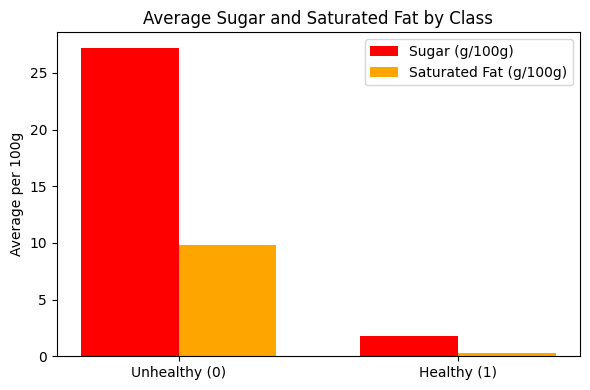

In [21]:

import matplotlib.pyplot as plt

# Calculate average sugar and saturated fat for each class
avg_values = df_model.groupby('label')[['sugars_100g', 'saturated-fat_100g']].mean()

# Prepare data for plotting
classes = ['Unhealthy (0)', 'Healthy (1)']
sugar_means = avg_values['sugars_100g'].values
satfat_means = avg_values['saturated-fat_100g'].values

# Create grouped bar chart
x = range(len(classes))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x, sugar_means, width, label='Sugar (g/100g)', color='red')
plt.bar([i + width for i in x], satfat_means, width, label='Saturated Fat (g/100g)', color='orange')

plt.xticks([i + width/2 for i in x], classes)
plt.ylabel('Average per 100g')
plt.title('Average Sugar and Saturated Fat by Class')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/poster_avg_nutrients.png', dpi=300)


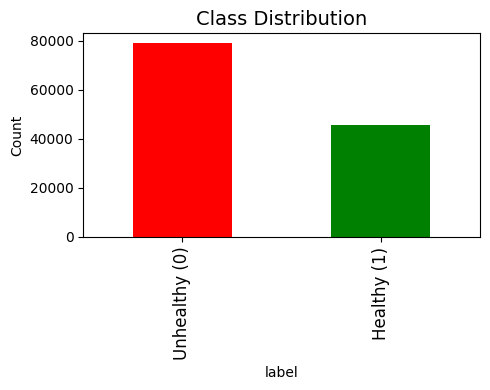

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
df_model["label"].value_counts().sort_index().plot(kind="bar", color=["red", "green"])
plt.xticks([0,1], ["Unhealthy (0)", "Healthy (1)"], fontsize=12)
plt.title("Class Distribution", fontsize=14)
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/poster_class_distribution.png", dpi=300)
plt.show()


In [16]:
# 3) Clean text, split train/test
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    return ' '.join(text.split())

df_model["clean_text"] = df_model["text"].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(
    df_model["clean_text"], df_model["label"],
    test_size=0.20, random_state=42, stratify=df_model["label"]
)


In [17]:
# 4) TF-IDF vectorization (shared for fair comparison)
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


In [22]:
# 5) Train Logistic Regression baseline
log_model = LogisticRegression(max_iter=300, class_weight='balanced')
log_model.fit(X_train_tfidf, y_train)
log_pred = log_model.predict(X_test_tfidf)
print("\nLogistic Regression")
print(classification_report(y_test, log_pred))



Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     15827
           1       0.88      0.95      0.91      9164

    accuracy                           0.93     24991
   macro avg       0.92      0.94      0.93     24991
weighted avg       0.94      0.93      0.93     24991



In [23]:
# 6) Train Linear SVM
svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)
print("\nLinear SVM")
print(classification_report(y_test, svm_pred))



Linear SVM
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     15827
           1       0.89      0.94      0.92      9164

    accuracy                           0.94     24991
   macro avg       0.93      0.94      0.93     24991
weighted avg       0.94      0.94      0.94     24991



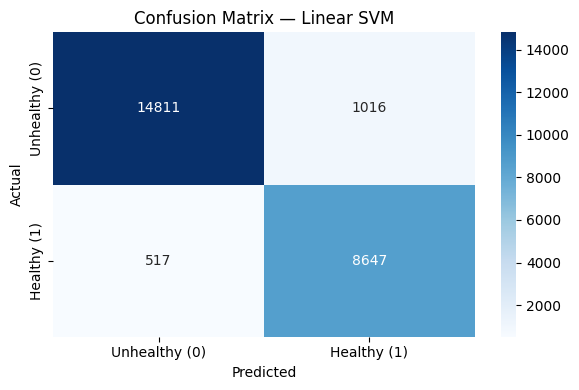

In [20]:
# 7) Confusion matrix (SVM)
cm = confusion_matrix(y_test, svm_pred)
labels = ["Unhealthy (0)", "Healthy (1)"]

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title("Confusion Matrix — Linear SVM")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/poster_confusion_svm.png', dpi=300)  # optional
plt.show()

# Alternatively using ConfusionMatrixDisplay:
# ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
# plt.title("Confusion Matrix — Linear SVM")
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/poster_confusion_svm.png', dpi=300)
# plt.show()
